In [10]:
from matplotlib import pyplot as plt 
from astropy import units as u
from photutils import DAOStarFinder
from astropy.io import fits
from astropy.visualization import *
from astropy.stats import mad_std

In [11]:
# --- Plot Parameters ---- 
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"] = 100
# plt.rc('font', family = 'serif', serif = 'cmr10') 
# plt.rcParams.update({# Use mathtext, not LaTeX
#                             'text.usetex': True,
#                             # Use the Computer modern font
#                             'font.family': 'serif',
#                             'font.serif': 'cmr10',
#                             'mathtext.fontset': 'cm',
#                             })
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
colour_arrays = ['red', 'blue', 'green', 'crimson', 'lime']

### DAO Starfinder 

In [45]:
def starfinder(data, thrs, plot_cond):

    mst_std = mad_std(data)
    daofind = DAOStarFinder(fwhm = 6., threshold = thrs*mst_std)
    mst_sources = daofind(data)

    for col in mst_sources.colnames: 
        mst_sources[col].info.format = '%.8g'

    if plot_cond == True: 
        plt.scatter(mst_sources['xcentroid'], mst_sources['ycentroid'], facecolors='none', edgecolors='lime')
        for i in range(0, len(mst_sources)):
            plt.annotate((i + 1), xy = (mst_sources['xcentroid'][i], mst_sources['ycentroid'][i]), fontsize= 5)
        plt.imshow(bochum2_B, vmin = bochum2_B.mean() - bochum2_B.std(), vmax = bochum2_B.mean() + bochum2_B.std(), cmap = 'gist_yarg'); plt.show()
        plt.show()

    return mst_sources

def save_Qtable(Qtable, filename):
    df = Qtable.to_pandas()
    df.to_csv(filename)
    

In [13]:
import os 
os.listdir('processed_data/')

['bochum2_V.fits',
 'berkeley28_B.fits',
 '.DS_Store',
 'NGC2355.jpeg',
 'berkeley28_V.fits',
 'bochum2_B.fits',
 'NGC2355_B.fits',
 'NGC2324_B.fits',
 'NGC2324.jpeg',
 'NGC2355_V.fits',
 'NGC2324_V.fits',
 'Berkeley28.png',
 'bFlat_Bmaster.fits',
 'normbFlat_Vmaster.fits',
 'Bochum2.png',
 'bFlat_Vmaster.fits',
 'normbFlat_Bmaster.fits',
 'master_bias.fits']

## Bochum 2 

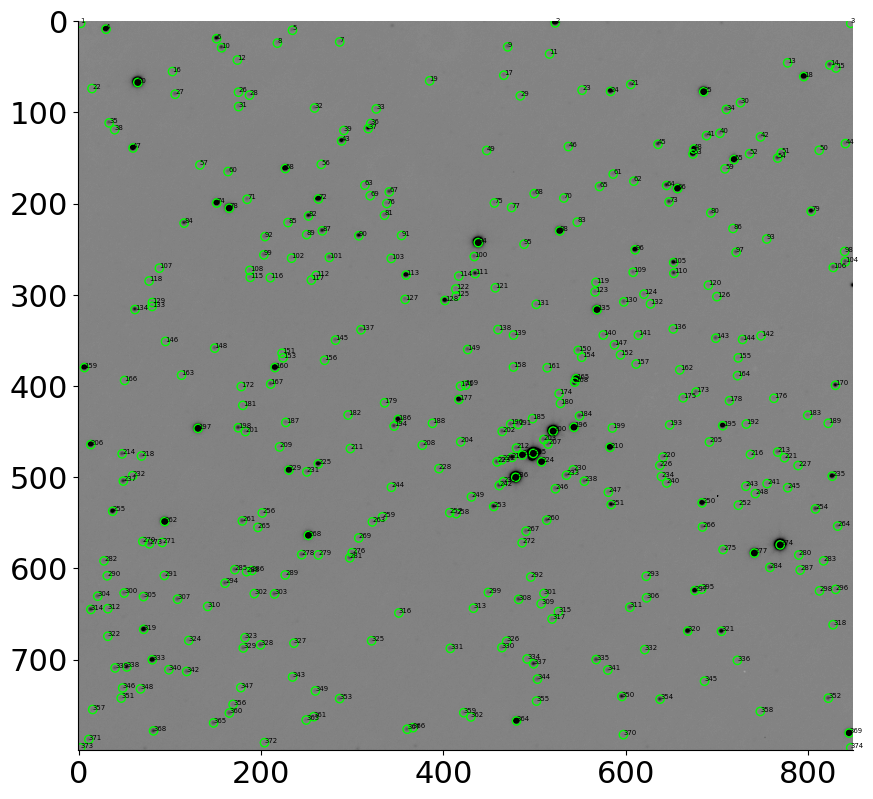

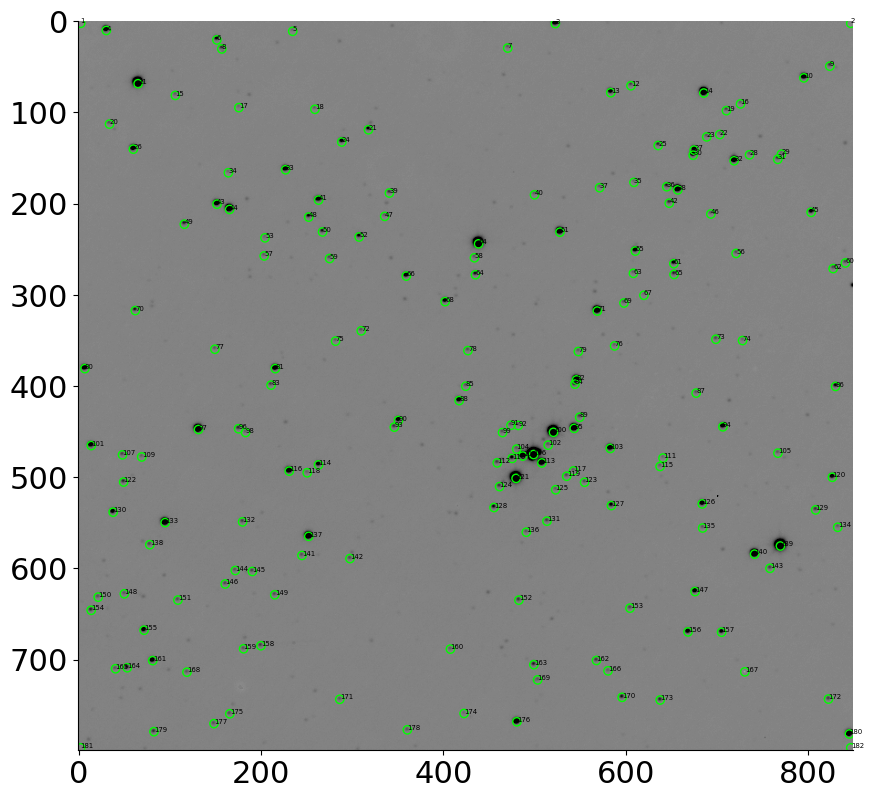

In [46]:
bochum2_B = fits.getdata('processed_data/bochum2_B.fits')
bochum2_sources__B = starfinder(bochum2_B, 6, True)
save_Qtable(bochum2_sources__B, 'processed_data/star_detection/bochum2_B.csv')

bochum2_V = fits.getdata('processed_data/bochum2_V.fits')
bochum2_sources__V = starfinder(bochum2_V, 6, True)

In [15]:
bochum2_sources__B

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,2.1878254,2.1864496,0.40738501,0.16043528,-0.00060366151,49,0,775.1837,185.14873,-5.6688018
2,522.66911,1.6541107,0.51502448,-0.47325959,-0.94354742,49,0,1598.7787,332.89373,-6.305764
3,846.8148,2.1855416,0.4081428,-0.16100188,0.00042362085,49,0,776.84178,185.43212,-5.6704624
4,29.995341,8.6511071,0.60229528,-0.05099129,-0.091129149,49,0,1292.222,127.14221,-5.2607244
5,234.47457,9.81939,0.58403915,-0.25062118,-0.26173747,49,0,796.00106,4.5599651,-1.6474038
6,637.04983,12.680303,0.37751741,-0.346969,-0.35338172,49,0,780.83672,1.1685462,-0.16911472
7,151.29216,19.033344,0.57286259,-0.036149122,-0.13644319,49,0,904.81569,32.497549,-3.7796265
8,286.29735,22.569309,0.51042347,-0.17964413,-0.024561727,49,0,791.8305,3.8244244,-1.4564152
9,217.95073,23.897239,0.73144708,0.00273066,-0.061503559,49,0,792.45624,3.1346661,-1.2404782


## Star Finder Comparison 

In [16]:
def find_nearest(array, value):
    array = np.asarray(array); idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [42]:
x1 = bochum2_sources__B['xcentroid']; y1 = bochum2_sources__B['ycentroid']
x2 = bochum2_sources__V['xcentroid']; y2 = bochum2_sources__V['ycentroid']

print(len(x1), len(x2))

common_stars = []

c = 1 
if len(x1) > len(x2):
    for x_cord in x2: 
        value, idx = find_nearest(x1, x_cord)
        print(abs(x_cord - value))
        if abs(x_cord - value) < 1: 
            common_x = x1[idx]; common_y = y1[idx]
            common_target = [common_x, common_y]
            common_stars.append(common_target)

print(len(common_stars), np.shape(common_stars))


374 182
0.014157863675519522
0.0020779382087994236
0.09329374073081453
0.3449341140484812
0.1453710372710475
0.1443265009920367
0.045623816711895415
0.2603040177201592
0.06303915428281925
0.11133839823446579
0.31349046839167727
0.19373048458373887
0.19591215396508233
0.13920372873485576
0.27231651162107084
0.03640727926506315
0.31082929175354934
0.3725538575696987
0.13042224502362387
0.39374732362902165
0.21776545647719558
0.1008118845129502
0.19241003536365042
0.14854763147917538
0.18294689963249766
0.2920179739058568
0.17176338682395453
0.06818761099782478
0.315204571696313
0.1487132460487146
0.08084862548435012
0.06430074943159525
0.21937009479341896
0.36875644796865004
0.09292020759676234
0.04892429186281788
0.14357307005377606
0.20675894010139473
0.13227846846172042
0.3041039373397325
0.16337781236899218
0.15891877294222923
0.333537787970414
0.2799698345290835
0.10753849345610433
0.04863940916220599
0.06305281083336922
0.2099856230911996
0.24164758578685053
0.28458642513174937
0.2

## Aperture Photometry 

In [ ]:
from photutils import * 

In [ ]:
def aper_photometry(data, sources):
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

    # Aperture and Annulus 
    aperture = CircularAperture(positions, r=6)
    annulus_aperture = CircularAnnulus(positions, r_in = 10, r_out = 15)
    apers = (aperture, annulus_aperture)

    phot_table = aperture_photometry(data, apers)
    print(annulus_aperture)

    # We calculate the mean counts in each pixel in the background annulus, and the n multiply by the area
    # in the aperture to get the total background counts within each aperture 
    bkg_mean = phot_table['aperture_sum_1']/annulus_aperture.area()
    bkg_sum = bkg_mean*aperture.area

    # # Now we get the final table of background subtracted counts within each aperture
    final_sum = phot_table['aperture_sum_0'] - bkg_sum

    return -2.5*np.log10(final_sum)

In [ ]:
# B_mag = aper_photometry(bochum2_B, bochum2_sources__B[common_stars_idx_B])

sources = bochum2_sources__B
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))


# Aperture and Annulus 
aperture = CircularAperture(positions, r=6)
annulus_aperture = CircularAnnulus(positions, r_in = 10, r_out = 15)
apers = (aperture, annulus_aperture)

phot_table = aperture_photometry(bochum2_B, apers)

# We calculate the mean counts in each pixel in the background annulus, and the n multiply by the area
# in the aperture to get the total background counts within each aperture 

bkg_mean = phot_table['aperture_sum_1']
bkg_sum = bkg_mean*aperture.area/annulus_aperture.area

# # Now we get the final table of background subtracted counts within each aperture
final_sum = phot_table['aperture_sum_0'] - bkg_sum

magnitude = -2.5*np.log10(final_sum)

print(magnitude)

   aperture_sum_0  
-------------------
 -10.93665391251589
 -10.99169435225222
-10.937601800341579
-11.121146760344903
-10.514728052560024
  -9.00425886608937
 -8.052356983641625
 -5.913625155756188
  -5.78290022625248
 -6.644989551683404
                ...
 -9.952479341582148
 -6.745524756689129
 -6.057792347569752
-6.6725217198526625
 -7.445736622139668
 -11.49653642001442
 -5.186222173466968
-10.680104863757121
-10.926885345308985
-10.938867126674767
-10.908689040711394
Length = 405 rows


<ipython-input-41-c1884ae185f4>:23: RuntimeWarning: invalid value encountered in log10
  magnitude = -2.5*np.log10(final_sum)
